# Texas Holdem Agents

In [58]:
import numpy as np
import collections
import os
import pickle
import itertools

import rlcard
from rlcard.utils.utils import remove_illegal
from rlcard.agents import CFRAgent, RandomAgent, DQNAgent
from rlcard.utils import tournament, Logger, plot_curve

from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Comparison Method

In [59]:
def compare_models(env_name, model1, model1_name, model2, model2_name, num_games=10000):
    """
    Compare two agents by swapping their seating positions and averaging results.
    """
    # Create a fresh evaluation environment
    eval_env = rlcard.make(env_name)
    
    # First seating: model1 as player 0, model2 as player 1
    eval_env.set_agents([model1, model2])
    rewards_order1 = tournament(eval_env, num_games)
    
    # Second seating: model2 as player 0, model1 as player 1
    eval_env.set_agents([model2, model1])
    rewards_order2 = tournament(eval_env, num_games)
    
    avg_reward_model1 = (rewards_order1[0] + rewards_order2[1]) / 2.0
    avg_reward_model2 = (rewards_order1[1] + rewards_order2[0]) / 2.0
    
    print(f"Average reward for {model1_name}: {avg_reward_model1:.4f}")
    print(f"Average reward for {model2_name}: {avg_reward_model2:.4f}")
    
    return avg_reward_model1, avg_reward_model2

## Original CFR Agent by RLCard

Iteration 0
----------------------------------------
  episode      |  192
  reward       |  0.0197
----------------------------------------
Iteration 50
----------------------------------------
  episode      |  9792
  reward       |  0.7154
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  19392
  reward       |  0.84195
----------------------------------------
Iteration 150
----------------------------------------
  episode      |  28992
  reward       |  0.83275
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  38592
  reward       |  0.82155
----------------------------------------
Iteration 250
----------------------------------------
  episode      |  48192
  reward       |  0.8155
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  57792
  reward       |  0.85445
----------------------------

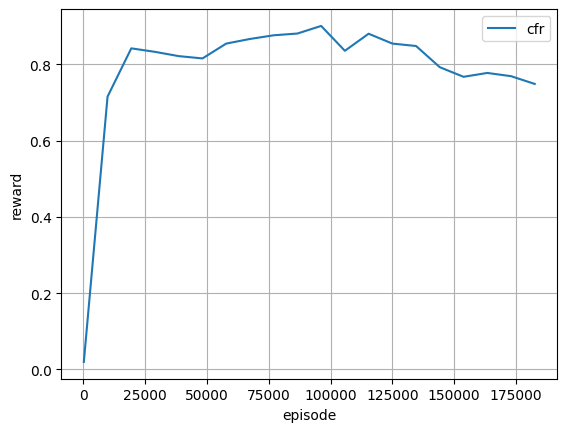

In [ ]:
env = rlcard.make(
        'leduc-holdem',
        config={
            'allow_step_back': True,
        }
    )
eval_env = rlcard.make(
    'leduc-holdem',
)

agent = CFRAgent(
    env,
    "experiments/leduc_holdem_cfr_result/cfr_model",
)

eval_env.set_agents([
    agent,
    RandomAgent(num_actions=env.num_actions),
])

with Logger("experiments/leduc_holdem_cfr_result") as logger:
    for episode in range(1000):
        agent.train()
        print('\rIteration {}'.format(episode), end='')
        if episode % 50 == 0:
            logger.log_performance(
                env.timestep,
                tournament(
                    eval_env,
                    10000,
                )[0]
            )

    csv_path, fig_path = logger.csv_path, logger.fig_path

plot_curve(csv_path, fig_path, 'cfr')

## Implementing CFR+ by Clipping Negative Regrets
Below is the modified agent class, called CFRPlusAgent, which is largely similar to the original CFR agent but with changes in the regret update and matching functions:

In [ ]:
class CFRPlusAgent():
    ''' Implement CFR+ algorithm with regret clipping '''

    def __init__(self, env, model_path='./cfr_model'):
        self.use_raw = False
        self.env = env
        self.model_path = model_path

        # A policy is a dict: state_str -> action probabilities
        self.policy = collections.defaultdict(list)
        self.average_policy = collections.defaultdict(lambda: np.zeros(env.num_actions))
        # Regrets: state_str -> action regrets (initialized as zeros)
        self.regrets = collections.defaultdict(lambda: np.zeros(env.num_actions))
        self.iteration = 0

    def train(self):
        self.iteration += 1
        for player_id in range(self.env.num_players):
            self.env.reset()
            probs = np.ones(self.env.num_players)
            self.traverse_tree(probs, player_id)
        self.update_policy()

    def traverse_tree(self, probs, player_id):
        '''Recursively traverse the game tree and update regrets'''
        if self.env.is_over():
            return self.env.get_payoffs()

        current_player = self.env.get_player_id()
        action_utilities = {}
        state_utility = np.zeros(self.env.num_players)
        obs, legal_actions = self.get_state(current_player)
        action_probs = self.action_probs(obs, legal_actions, self.policy)

        for action in legal_actions:
            action_prob = action_probs[action]
            new_probs = probs.copy()
            new_probs[current_player] *= action_prob

            self.env.step(action)
            utility = self.traverse_tree(new_probs, player_id)
            self.env.step_back()

            state_utility += action_prob * utility
            action_utilities[action] = utility

        # If not the current player, return the computed state utility
        if current_player != player_id:
            return state_utility

        # For the current player, update regrets and the average policy
        player_prob = probs[current_player]
        counterfactual_prob = (np.prod(probs[:current_player]) *
                               np.prod(probs[current_player + 1:]))
        player_state_utility = state_utility[current_player]

        # Initialize storage if necessary
        if obs not in self.regrets:
            self.regrets[obs] = np.zeros(self.env.num_actions)
        if obs not in self.average_policy:
            self.average_policy[obs] = np.zeros(self.env.num_actions)

        for action in legal_actions:
            action_prob = action_probs[action]
            regret = counterfactual_prob * (action_utilities[action][current_player] - player_state_utility)
            # CFR+ update: clip the cumulative regret to zero (do not allow negative regrets)
            self.regrets[obs][action] = max(0, self.regrets[obs][action] + regret)
            self.average_policy[obs][action] += self.iteration * player_prob * action_prob

        return state_utility

    def update_policy(self):
        '''Update policy based on current regrets using regret matching'''
        for obs in self.regrets:
            self.policy[obs] = self.regret_matching(obs)

    def regret_matching(self, obs):
        '''Calculate action probabilities by normalizing the positive regrets'''
        regret = self.regrets[obs]
        # Only use non-negative regrets (CFR+)
        regret_plus = np.maximum(regret, 0)
        positive_regret_sum = np.sum(regret_plus)
        action_probs = np.zeros(self.env.num_actions)
        if positive_regret_sum > 0:
            action_probs = regret_plus / positive_regret_sum
        else:
            action_probs.fill(1.0 / self.env.num_actions)
        return action_probs

    def action_probs(self, obs, legal_actions, policy):
        if obs not in policy:
            action_probs = np.array([1.0 / self.env.num_actions for _ in range(self.env.num_actions)])
            self.policy[obs] = action_probs
        else:
            action_probs = policy[obs]
        action_probs = remove_illegal(action_probs, legal_actions)
        return action_probs

    def eval_step(self, state):
        probs = self.action_probs(state['obs'].tostring(), list(state['legal_actions'].keys()), self.average_policy)
        action = np.random.choice(len(probs), p=probs)
        info = {
            'probs': {
                state['raw_legal_actions'][i]: float(probs[list(state['legal_actions'].keys())[i]])
                for i in range(len(state['legal_actions']))
            }
        }
        return action, info

    def get_state(self, player_id):
        state = self.env.get_state(player_id)
        return state['obs'].tostring(), list(state['legal_actions'].keys())

    def save(self):
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
        with open(os.path.join(self.model_path, 'policy.pkl'), 'wb') as f:
            pickle.dump(self.policy, f)
        with open(os.path.join(self.model_path, 'average_policy.pkl'), 'wb') as f:
            pickle.dump(self.average_policy, f)
        with open(os.path.join(self.model_path, 'regrets.pkl'), 'wb') as f:
            pickle.dump(self.regrets, f)
        with open(os.path.join(self.model_path, 'iteration.pkl'), 'wb') as f:
            pickle.dump(self.iteration, f)

    def load(self):
        if not os.path.exists(self.model_path):
            return
        with open(os.path.join(self.model_path, 'policy.pkl'), 'rb') as f:
            self.policy = pickle.load(f)
        with open(os.path.join(self.model_path, 'average_policy.pkl'), 'rb') as f:
            self.average_policy = pickle.load(f)
        with open(os.path.join(self.model_path, 'regrets.pkl'), 'rb') as f:
            self.regrets = pickle.load(f)
        with open(os.path.join(self.model_path, 'iteration.pkl'), 'rb') as f:
            self.iteration = pickle.load(f)


Iteration 0

/var/folders/lx/83qzj14d62j7kt5mrql9j7n80000gn/T/ipykernel_7415/3842757341.py:117: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return state['obs'].tostring(), list(state['legal_actions'].keys())
/var/folders/lx/83qzj14d62j7kt5mrql9j7n80000gn/T/ipykernel_7415/3842757341.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  probs = self.action_probs(state['obs'].tostring(), list(state['legal_actions'].keys()), self.average_policy)



----------------------------------------
  episode      |  192
  reward       |  -0.02
----------------------------------------
Iteration 50
----------------------------------------
  episode      |  9792
  reward       |  0.4308
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  19392
  reward       |  0.60965
----------------------------------------
Iteration 150
----------------------------------------
  episode      |  28992
  reward       |  0.6012
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  38592
  reward       |  0.6555
----------------------------------------
Iteration 250
----------------------------------------
  episode      |  48192
  reward       |  0.63985
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  57792
  reward       |  0.7032
----------------------------------------
I

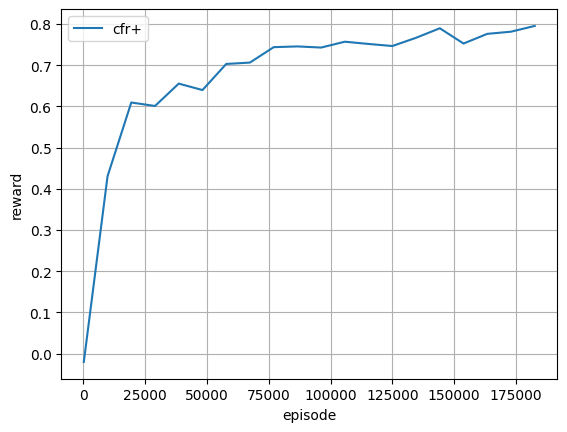

In [62]:
env = rlcard.make(
    'leduc-holdem',
    config={
        'allow_step_back': True,
    }
)
eval_env = rlcard.make('leduc-holdem')

agent = CFRPlusAgent(
    env,
    "experiments/leduc_holdem_cfr_plus_result/cfr_model",
)

eval_env.set_agents([
    agent,
    RandomAgent(num_actions=env.num_actions),
])

# Training and evaluation loop
with Logger("experiments/leduc_holdem_cfr_plus_result") as logger:
    for episode in range(1000):
        agent.train()
        print('\rIteration {}'.format(episode), end='')
        # Evaluate performance every 50 episodes using a tournament with 10,000 games
        if episode % 50 == 0:
            performance = tournament(eval_env, 10000)[0]
            logger.log_performance(env.timestep, performance)

    # Retrieve log paths for plotting
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the performance curve
plot_curve(csv_path, fig_path, 'cfr+')


### CFR (original) vs CFR+

In [63]:
env = rlcard.make(
    'leduc-holdem',
    config={'allow_step_back': True}
)

eval_env = rlcard.make('leduc-holdem')

cfr_agent = CFRAgent(
    env,
    "experiments/leduc_holdem_cfr_result/cfr_model"
)
cfr_agent.load()  

cfr_plus_agent = CFRPlusAgent(
    env,
    "experiments/leduc_holdem_cfr_plus_result/cfr_model"
)
cfr_plus_agent.load()  

compare_models('leduc-holdem', cfr_agent, "CFR", cfr_plus_agent, "CFR+")

/var/folders/lx/83qzj14d62j7kt5mrql9j7n80000gn/T/ipykernel_7415/3842757341.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  probs = self.action_probs(state['obs'].tostring(), list(state['legal_actions'].keys()), self.average_policy)


Average reward for CFR: -0.0026
Average reward for CFR+: 0.0026


(np.float64(-0.0026249999999999997), np.float64(0.0026249999999999997))

The final average rewards from the comparison are very close to zero—with CFR at about 0.0038 and CFR+ at about -0.0038. In a zero-sum game like Leduc Hold'em, a near-zero average reward usually means that the agent is performing close to Nash equilibrium against a random opponent. In other words, neither agent has a significant advantage over the other when averaged across many games.

## CFRPlus + baseline
Below is a version of the CFR+ agent that incorporates a simple baseline variance reduction technique. In this version, we add a dictionary to keep a moving average baseline for each observed state. Then, in the tree traversal, we subtract this baseline (instead of the raw state‐value) when updating the regrets. This can help reduce variance by centering the utility differences around a more stable target.

In [ ]:
class CFRPlusAgentWithBaseline():
    '''CFR+ agent with baseline variance reduction.
    A baseline (moving average) is maintained per state and used to center
    the utility differences during regret updates.
    '''

    def __init__(self, env, model_path='./cfr_model'):
        self.use_raw = False
        self.env = env
        self.model_path = model_path

        # Policy: state_str -> action probabilities
        self.policy = collections.defaultdict(list)
        # Average policy: state_str -> average action probabilities
        self.average_policy = collections.defaultdict(lambda: np.zeros(env.num_actions))
        # Regrets: state_str -> cumulative regrets (initialized to zeros)
        self.regrets = collections.defaultdict(lambda: np.zeros(env.num_actions))
        # Baseline: state_str -> moving average of state value (for variance reduction)
        self.baselines = collections.defaultdict(float)

        self.iteration = 0

    def train(self):
        self.iteration += 1
        for player_id in range(self.env.num_players):
            self.env.reset()
            probs = np.ones(self.env.num_players)
            self.traverse_tree(probs, player_id)
        self.update_policy()

    def traverse_tree(self, probs, player_id):
        if self.env.is_over():
            return self.env.get_payoffs()

        current_player = self.env.get_player_id()
        action_utilities = {}
        state_utility = np.zeros(self.env.num_players)
        obs, legal_actions = self.get_state(current_player)
        action_probs = self.action_probs(obs, legal_actions, self.policy)

        for action in legal_actions:
            act_prob = action_probs[action]
            new_probs = probs.copy()
            new_probs[current_player] *= act_prob

            self.env.step(action)
            utility = self.traverse_tree(new_probs, player_id)
            self.env.step_back()

            state_utility += act_prob * utility
            action_utilities[action] = utility

        if current_player != player_id:
            return state_utility

        # For the current player, update regrets using a baseline
        player_prob = probs[current_player]
        counterfactual_prob = (np.prod(probs[:current_player]) *
                               np.prod(probs[current_player+1:]))
        player_state_utility = state_utility[current_player]

        # Update baseline as a moving average for the state
        prev_baseline = self.baselines[obs]
        self.baselines[obs] = ((prev_baseline * (self.iteration - 1)) + player_state_utility) / self.iteration

        # Use the updated baseline for variance reduction in the regret update
        for action in legal_actions:
            act_prob = action_probs[action]
            # Compute regret relative to the baseline rather than state utility
            regret = counterfactual_prob * (action_utilities[action][current_player] - self.baselines[obs])
            # CFR+ update: clip cumulative regret to non-negative values
            self.regrets[obs][action] = max(0, self.regrets[obs][action] + regret)
            self.average_policy[obs][action] += self.iteration * player_prob * act_prob

        return state_utility

    def update_policy(self):
        for obs in self.regrets:
            self.policy[obs] = self.regret_matching(obs)

    def regret_matching(self, obs):
        regret = self.regrets[obs]
        regret_plus = np.maximum(regret, 0)
        total_positive = regret_plus.sum()
        action_probs = np.zeros(self.env.num_actions)
        if total_positive > 0:
            action_probs = regret_plus / total_positive
        else:
            action_probs.fill(1.0 / self.env.num_actions)
        return action_probs

    def action_probs(self, obs, legal_actions, policy):
        if obs not in policy:
            action_probs = np.array([1.0 / self.env.num_actions for _ in range(self.env.num_actions)])
            self.policy[obs] = action_probs
        else:
            action_probs = policy[obs]
        action_probs = remove_illegal(action_probs, legal_actions)
        return action_probs

    def eval_step(self, state):
        obs = state['obs'].tobytes()
        legal_actions = list(state['legal_actions'].keys())
        probs = self.action_probs(obs, legal_actions, self.average_policy)
        action = np.random.choice(len(probs), p=probs)
        info = {
            'probs': {state['raw_legal_actions'][i]: float(probs[list(state['legal_actions'].keys())[i]])
                      for i in range(len(state['legal_actions']))}
        }
        return action, info

    def get_state(self, player_id):
        state = self.env.get_state(player_id)
        return state['obs'].tobytes(), list(state['legal_actions'].keys())

    def save(self):
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
        with open(os.path.join(self.model_path, 'policy.pkl'), 'wb') as f:
            pickle.dump(self.policy, f)
        with open(os.path.join(self.model_path, 'average_policy.pkl'), 'wb') as f:
            pickle.dump(self.average_policy, f)
        with open(os.path.join(self.model_path, 'regrets.pkl'), 'wb') as f:
            pickle.dump(self.regrets, f)
        with open(os.path.join(self.model_path, 'baseline.pkl'), 'wb') as f:
            pickle.dump(self.baselines, f)
        with open(os.path.join(self.model_path, 'iteration.pkl'), 'wb') as f:
            pickle.dump(self.iteration, f)

    def load(self):
        if not os.path.exists(self.model_path):
            return
        with open(os.path.join(self.model_path, 'policy.pkl'), 'rb') as f:
            self.policy = pickle.load(f)
        with open(os.path.join(self.model_path, 'average_policy.pkl'), 'rb') as f:
            self.average_policy = pickle.load(f)
        with open(os.path.join(self.model_path, 'regrets.pkl'), 'rb') as f:
            self.regrets = pickle.load(f)
        with open(os.path.join(self.model_path, 'baseline.pkl'), 'rb') as f:
            self.baselines = pickle.load(f)
        with open(os.path.join(self.model_path, 'iteration.pkl'), 'rb') as f:
            self.iteration = pickle.load(f)


Iteration 0
----------------------------------------
  episode      |  192
  reward       |  -0.0097
----------------------------------------
Iteration 50
----------------------------------------
  episode      |  9792
  reward       |  0.77555
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  19392
  reward       |  0.786
----------------------------------------
Iteration 150
----------------------------------------
  episode      |  28992
  reward       |  0.8002
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  38592
  reward       |  0.8843
----------------------------------------
Iteration 250
----------------------------------------
  episode      |  48192
  reward       |  0.8759
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  57792
  reward       |  0.80385
------------------------------

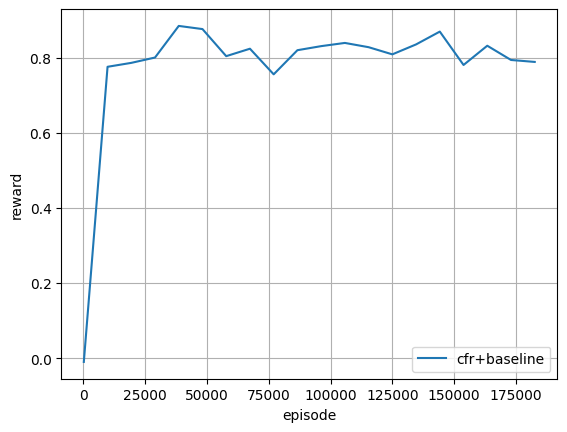

In [65]:
env = rlcard.make(
    'leduc-holdem',
    config={'allow_step_back': True}
)
eval_env = rlcard.make('leduc-holdem')

agent = CFRPlusAgentWithBaseline(
    env,
    "experiments/leduc_holdem_cfr_plus_baseline_result/cfr_model"
)

eval_env.set_agents([
    agent,
    RandomAgent(num_actions=env.num_actions),
])

with Logger("experiments/leduc_holdem_cfr_plus_baseline_result") as logger:
    for episode in range(1000):
        agent.train()
        print('\rIteration {}'.format(episode), end='')
        if episode % 50 == 0:
            performance = tournament(eval_env, 10000)[0]
            logger.log_performance(env.timestep, performance)

    csv_path, fig_path = logger.csv_path, logger.fig_path

plot_curve(csv_path, fig_path, 'cfr+baseline')

In [66]:
env = rlcard.make(
    'leduc-holdem',
    config={'allow_step_back': True}
)

eval_env = rlcard.make('leduc-holdem')

cfr_agent = CFRAgent(
    env,
    "experiments/leduc_holdem_cfr_result/cfr_model"
)
cfr_agent.load() 

cfr_plus_agent = CFRPlusAgent(
    env,
    "experiments/leduc_holdem_cfr_plus_result/cfr_model"
)
cfr_plus_agent.load()

compare_models('leduc-holdem', cfr_agent, "CFR", cfr_plus_agent, "CFR+")

/var/folders/lx/83qzj14d62j7kt5mrql9j7n80000gn/T/ipykernel_7415/3842757341.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  probs = self.action_probs(state['obs'].tostring(), list(state['legal_actions'].keys()), self.average_policy)


Average reward for CFR: -0.0026
Average reward for CFR+: 0.0026


(np.float64(-0.0025749999999999996), np.float64(0.0025749999999999996))

### CFR vs CFRPlus+baseline

In [67]:
env = rlcard.make('leduc-holdem', config={'allow_step_back': True})
cfr_agent = CFRAgent(env, "experiments/leduc_holdem_cfr_result/cfr_model")
cfr_agent.load()

cfr_baseline_agent = CFRPlusAgentWithBaseline(env, "experiments/leduc_holdem_cfr_plus_baseline_result/cfr_model")
cfr_baseline_agent.load()

In [68]:
compare_models('leduc-holdem', cfr_agent, "CFRAgent", cfr_baseline_agent, "CFR+ with Baseline", num_games=10000)

Average reward for CFRAgent: -0.0153
Average reward for CFR+ with Baseline: 0.0153


(np.float64(-0.015325), np.float64(0.015325))

The results imply that both agents are performing nearly equally well, with a minor edge (0.01795 per game) that might not be statistically significant.

## CFRPlus + Baseline + Abstract

Instead of using the raw state representation (e.g., a long binary or numerical vector), we extract key features. For example, in card game, we could summarize information such as hand strength, position, or betting history. For more complex games, we can use dimensionality reduction techniques like PCA or even autoencoders.

In [ ]:
class StateAbstraction:
    def __init__(self, n_clusters=100):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.fitted = False

    def fit(self, state_samples):
        """
        Fit the clustering model on a collection of state samples.
        """
        self.kmeans.fit(state_samples)
        self.fitted = True

    def abstract_state(self, state):
        """
        Map a raw state (numeric vector) into its abstract state label.
        """
        if not self.fitted:
            raise ValueError("StateAbstraction model is not fitted. Call fit() with state samples first.")
        state = np.array(state).reshape(1, -1)
        label = self.kmeans.predict(state)[0]
        return str(label)

class CFRPlusAgentWithBaselineAbstract():
    """
    CFR+ agent with baseline variance reduction and state abstraction.
    This agent uses a clustering mechanism (KMeans) to compress the state space.
    """
    def __init__(self, env, model_path='./cfr_model', n_clusters=100):
        self.use_raw = False
        self.env = env
        self.model_path = model_path

        # Dictionaries to hold the tabular values.
        self.policy = collections.defaultdict(list)
        self.average_policy = collections.defaultdict(lambda: np.zeros(env.num_actions))
        self.regrets = collections.defaultdict(lambda: np.zeros(env.num_actions))
        self.baselines = collections.defaultdict(float)
        self.iteration = 0

        # Initialize state abstraction.
        self.abstraction = StateAbstraction(n_clusters=n_clusters)

    def train(self):
        self.iteration += 1
        for player_id in range(self.env.num_players):
            self.env.reset()
            probs = np.ones(self.env.num_players)
            self.traverse_tree(probs, player_id)
        self.update_policy()

    def traverse_tree(self, probs, player_id):
        if self.env.is_over():
            return self.env.get_payoffs()

        current_player = self.env.get_player_id()
        action_utilities = {}
        state_utility = np.zeros(self.env.num_players)
        # Use abstract state instead of raw state
        obs, legal_actions = self.get_state(current_player)
        action_probs = self.action_probs(obs, legal_actions, self.policy)

        for action in legal_actions:
            act_prob = action_probs[action]
            new_probs = probs.copy()
            new_probs[current_player] *= act_prob

            self.env.step(action)
            utility = self.traverse_tree(new_probs, player_id)
            self.env.step_back()

            state_utility += act_prob * utility
            action_utilities[action] = utility

        if current_player != player_id:
            return state_utility

        player_prob = probs[current_player]
        counterfactual_prob = (np.prod(probs[:current_player]) *
                               np.prod(probs[current_player+1:]))
        player_state_utility = state_utility[current_player]

        # Update baseline for this abstract state
        prev_baseline = self.baselines[obs]
        self.baselines[obs] = ((prev_baseline * (self.iteration - 1)) + player_state_utility) / self.iteration

        for action in legal_actions:
            act_prob = action_probs[action]
            regret = counterfactual_prob * (action_utilities[action][current_player] - self.baselines[obs])
            self.regrets[obs][action] = max(0, self.regrets[obs][action] + regret)
            self.average_policy[obs][action] += self.iteration * player_prob * act_prob

        return state_utility

    def update_policy(self):
        for obs in self.regrets:
            self.policy[obs] = self.regret_matching(obs)

    def regret_matching(self, obs):
        regret = self.regrets[obs]
        regret_plus = np.maximum(regret, 0)
        total_positive = regret_plus.sum()
        action_probs = np.zeros(self.env.num_actions)
        if total_positive > 0:
            action_probs = regret_plus / total_positive
        else:
            action_probs.fill(1.0 / self.env.num_actions)
        return action_probs

    def action_probs(self, obs, legal_actions, policy):
        if obs not in policy:
            action_probs = np.array([1.0 / self.env.num_actions for _ in range(self.env.num_actions)])
            self.policy[obs] = action_probs
        else:
            action_probs = policy[obs]
        action_probs = remove_illegal(action_probs, legal_actions)
        return action_probs

    def eval_step(self, state):
        # In evaluation, obtain the raw state (assumed to be a numpy array), flatten it, and abstract.
        raw_state = state['obs'] 
        numeric_state = raw_state.flatten()
        try:
            abstract_state = self.abstraction.abstract_state(numeric_state)
        except ValueError:
            abstract_state = raw_state.tobytes()  # fallback if not fitted
        legal_actions = list(state['legal_actions'].keys())
        probs = self.action_probs(abstract_state, legal_actions, self.average_policy)
        action = np.random.choice(len(probs), p=probs)
        info = {
            'probs': {state['raw_legal_actions'][i]: float(probs[list(state['legal_actions'].keys())[i]])
                      for i in range(len(state['legal_actions']))}
        }
        return action, info

    def get_state(self, player_id):
        state = self.env.get_state(player_id)
        # Assume state['obs'] is a numpy array; flatten to a 1D vector.
        numeric_state = state['obs'].flatten()
        try:
            abstract_state = self.abstraction.abstract_state(numeric_state)
        except ValueError:
            # If abstraction not yet fitted, fall back to raw bytes (or consider raising an error)
            abstract_state = state['obs'].tobytes()
        legal_actions = list(state['legal_actions'].keys())
        return abstract_state, legal_actions

    def save(self):
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
        with open(os.path.join(self.model_path, 'policy.pkl'), 'wb') as f:
            pickle.dump(self.policy, f)
        with open(os.path.join(self.model_path, 'average_policy.pkl'), 'wb') as f:
            pickle.dump(self.average_policy, f)
        with open(os.path.join(self.model_path, 'regrets.pkl'), 'wb') as f:
            pickle.dump(self.regrets, f)
        with open(os.path.join(self.model_path, 'baseline.pkl'), 'wb') as f:
            pickle.dump(self.baselines, f)
        with open(os.path.join(self.model_path, 'iteration.pkl'), 'wb') as f:
            pickle.dump(self.iteration, f)
        with open(os.path.join(self.model_path, 'abstraction.pkl'), 'wb') as f:
            pickle.dump(self.abstraction, f)

    def load(self):
        if not os.path.exists(self.model_path):
            return
        with open(os.path.join(self.model_path, 'policy.pkl'), 'rb') as f:
            self.policy = pickle.load(f)
        with open(os.path.join(self.model_path, 'average_policy.pkl'), 'rb') as f:
            self.average_policy = pickle.load(f)
        with open(os.path.join(self.model_path, 'regrets.pkl'), 'rb') as f:
            self.regrets = pickle.load(f)
        with open(os.path.join(self.model_path, 'baseline.pkl'), 'rb') as f:
            self.baselines = pickle.load(f)
        with open(os.path.join(self.model_path, 'iteration.pkl'), 'rb') as f:
            self.iteration = pickle.load(f)
        with open(os.path.join(self.model_path, 'abstraction.pkl'), 'rb') as f:
            self.abstraction = pickle.load(f)


In [70]:
state_samples = []
for _ in range(1000):
    env.reset()
    for player_id in range(env.num_players):
        state = env.get_state(player_id)['obs']
        state_samples.append(state.flatten())
state_samples = np.array(state_samples)
agent = CFRPlusAgentWithBaselineAbstract(env, model_path="experiments/leduc_holdem_cfr_plus_baseline_abstract_result/cfr_model")
agent.abstraction.fit(state_samples)

/Users/jojog/miniconda3/envs/TexasHoldemRLCard/lib/python3.9/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (100). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Iteration 0
----------------------------------------
  episode      |  192
  reward       |  0.00265
----------------------------------------
Iteration 50
----------------------------------------
  episode      |  9792
  reward       |  0.8073
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  19392
  reward       |  0.93135
----------------------------------------
Iteration 150
----------------------------------------
  episode      |  28992
  reward       |  0.9958
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  38592
  reward       |  0.92175
----------------------------------------
Iteration 250
----------------------------------------
  episode      |  48192
  reward       |  0.91725
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  57792
  reward       |  0.881
-----------------------------

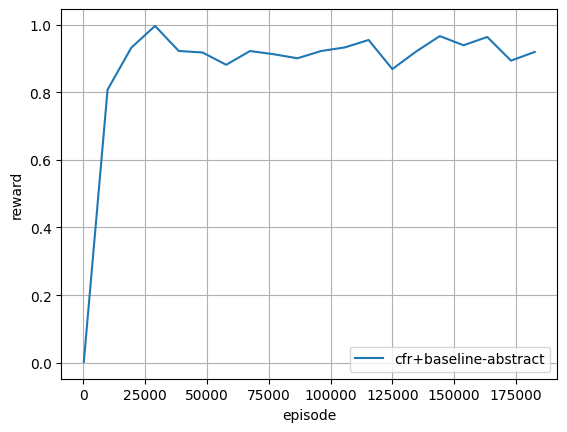

In [71]:
env = rlcard.make('leduc-holdem', config={'allow_step_back': True})
eval_env = rlcard.make('leduc-holdem')

agent = CFRPlusAgentWithBaselineAbstract(
    env,
    model_path="experiments/leduc_holdem_cfr_plus_baseline_abstract_result/cfr_model",
    n_clusters=100 
)

eval_env.set_agents([
    agent,
    RandomAgent(num_actions=env.num_actions),
])

with Logger("experiments/leduc_holdem_cfr_plus_baseline_abstract_result") as logger:
    for episode in range(1000):
        agent.train()
        print(f"\rIteration {episode}", end='')
        if episode % 50 == 0:
            performance = tournament(eval_env, 10000)[0]
            logger.log_performance(env.timestep, performance)

    csv_path, fig_path = logger.csv_path, logger.fig_path

plot_curve(csv_path, fig_path, 'cfr+baseline-abstract')

In [72]:
env = rlcard.make('leduc-holdem', config={'allow_step_back': True})

cfr_agent = CFRAgent(env, "experiments/leduc_holdem_cfr_result/cfr_model")
cfr_agent.load()

cfr_abstract_agent = CFRPlusAgentWithBaselineAbstract(
    env,
    model_path="experiments/leduc_holdem_cfr_plus_baseline_abstract_result/cfr_model",
    n_clusters=100  
)
cfr_abstract_agent.load()

compare_models('leduc-holdem', cfr_agent, "CFRAgent", cfr_abstract_agent, "CFR+ with Baseline & Abstraction", num_games=100)

Average reward for CFRAgent: 0.2450
Average reward for CFR+ with Baseline & Abstraction: -0.2450


(np.float64(0.245), np.float64(-0.245))

## Deep CFR + above (simplified)

Adapting the above CFR+ with baseline and state abstraction approach into a Deep CFR–style agent. In Deep CFR, rather than storing tabular regrets and policies, we approximate them with neural networks. This snippet illustrates the core ideas:

Two Neural Networks:

A regret network that approximates counterfactual regrets for each action in a given state.
A policy (strategy) network that approximates the average policy.
Replay Buffers:

A regret buffer that stores (state, counterfactual regret) samples.
A policy buffer that stores (state, action probabilities) samples for training the average policy.
State Abstraction (as in your existing code) to cluster or compress states before passing them to the neural nets.

In [ ]:
# Data classes
RegretSample = collections.namedtuple('RegretSample', ['state', 'regret'])
PolicySample = collections.namedtuple('PolicySample', ['state', 'action_probs'])

class StateAbstraction:
    def __init__(self, n_clusters=150):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.fitted = False

    def fit(self, state_samples):
        self.kmeans.fit(state_samples)
        self.fitted = True

    def abstract_state(self, state):
        if not self.fitted:
            raise ValueError("StateAbstraction model is not fitted. Call fit() with state samples first.")
        state = np.array(state).reshape(1, -1)
        label = self.kmeans.predict(state)[0]
        return str(label)

class RegretNet(nn.Module):
    def __init__(self, input_dim, num_actions, hidden_sizes=[256, 256]):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, num_actions))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class PolicyNet(nn.Module):
    def __init__(self, input_dim, num_actions, hidden_sizes=[256, 256]):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, num_actions))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.net(x)
        return F.softmax(logits, dim=-1)

class DeepCFRAgent:
    def __init__(
        self,
        env,
        model_path='./deepcfr_model',
        n_clusters=150,
        regret_hidden_sizes=[256,256],
        policy_hidden_sizes=[256,256],
        device=None,
        lr=1e-4,         # Lowered learning rate for more stable training
        batch_size=128,  # Larger batch size
        gather_episodes=10  # Gather data over multiple episodes before training
    ):
        self.env = env
        self.model_path = model_path
        self.use_raw = False
        self.num_actions = env.num_actions

        # Baseline dictionary for variance reduction
        self.baselines = collections.defaultdict(float)

        # State abstraction
        self.abstraction = StateAbstraction(n_clusters=n_clusters)
        self.input_dim = n_clusters

        # Build neural networks
        self.regret_net = RegretNet(self.input_dim, self.num_actions, regret_hidden_sizes)
        self.policy_net = PolicyNet(self.input_dim, self.num_actions, policy_hidden_sizes)

        self.device = device if device else torch.device('cpu')
        self.regret_net.to(self.device)
        self.policy_net.to(self.device)

        # Optimizers
        self.regret_optimizer = optim.Adam(self.regret_net.parameters(), lr=lr)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        self.batch_size = batch_size
        self.iteration = 0

        # Buffers for storing data each iteration
        self.regret_buffer = []
        self.policy_buffer = []

        # Number of episodes to gather data before each train() call
        self.gather_episodes = gather_episodes

    def train(self):
        """
        Main Deep CFR iteration:
         1. Gather data for self.gather_episodes
         2. Update networks with the collected data
        """
        self.iteration += 1
        # Clear buffers
        self.regret_buffer.clear()
        self.policy_buffer.clear()

        # Gather data over multiple episodes
        for _ in range(self.gather_episodes):
            for player_id in range(self.env.num_players):
                self.env.reset()
                probs = np.ones(self.env.num_players)
                self.traverse_tree(probs, player_id)

        # Now train from the buffers
        self.train_regret_net()
        self.train_policy_net()

    def traverse_tree(self, probs, player_id):
        if self.env.is_over():
            return self.env.get_payoffs()

        current_player = self.env.get_player_id()
        action_utilities = {}
        state_utility = np.zeros(self.env.num_players)

        obs, legal_actions = self.get_state(current_player)
        action_probs = self.action_probs(obs, legal_actions)

        for action in legal_actions:
            act_prob = action_probs[action]
            new_probs = probs.copy()
            new_probs[current_player] *= act_prob

            self.env.step(action)
            utility = self.traverse_tree(new_probs, player_id)
            self.env.step_back()

            state_utility += act_prob * utility
            action_utilities[action] = utility

        if current_player != player_id:
            return state_utility

        player_prob = probs[current_player]
        counterfactual_prob = (np.prod(probs[:current_player]) *
                               np.prod(probs[current_player + 1:]))

        player_state_utility = state_utility[current_player]
        prev_baseline = self.baselines[obs]
        self.baselines[obs] = ((prev_baseline * (self.iteration - 1)) + player_state_utility) / self.iteration

        policy_sample = PolicySample(state=obs, action_probs=action_probs)
        self.policy_buffer.append(policy_sample)

        for action in legal_actions:
            regret_value = (action_utilities[action][current_player] - self.baselines[obs]) * counterfactual_prob
            self.regret_buffer.append(RegretSample(
                state=obs,
                regret=self._one_hot_regret(action, regret_value)
            ))
        return state_utility

    def train_regret_net(self):
        if not self.regret_buffer:
            return
        np.random.shuffle(self.regret_buffer)

        for start_idx in range(0, len(self.regret_buffer), self.batch_size):
            end_idx = start_idx + self.batch_size
            batch = self.regret_buffer[start_idx:end_idx]
            states, regrets = [], []
            for sample in batch:
                states.append(self._obs_to_vec(sample.state))
                regrets.append(sample.regret)
            states = torch.tensor(states, dtype=torch.float32, device=self.device)
            regrets = torch.tensor(regrets, dtype=torch.float32, device=self.device)

            pred = self.regret_net(states)
            loss = F.mse_loss(pred, regrets)

            self.regret_optimizer.zero_grad()
            loss.backward()
            self.regret_optimizer.step()

    def train_policy_net(self):
        if not self.policy_buffer:
            return
        np.random.shuffle(self.policy_buffer)

        for start_idx in range(0, len(self.policy_buffer), self.batch_size):
            end_idx = start_idx + self.batch_size
            batch = self.policy_buffer[start_idx:end_idx]
            states, action_probs = [], []
            for sample in batch:
                states.append(self._obs_to_vec(sample.state))
                action_probs.append(sample.action_probs)
            states = torch.tensor(states, dtype=torch.float32, device=self.device)
            action_probs = torch.tensor(action_probs, dtype=torch.float32, device=self.device)

            pred = self.policy_net(states)
            loss = -torch.sum(action_probs * torch.log(pred + 1e-8), dim=1).mean()

            self.policy_optimizer.zero_grad()
            loss.backward()
            self.policy_optimizer.step()

    def action_probs(self, obs, legal_actions):
        # Convert cluster label to one-hot
        state_vec = self._obs_to_vec(obs)
        with torch.no_grad():
            state_tensor = torch.tensor(state_vec, dtype=torch.float32, device=self.device).unsqueeze(0)
            probs = self.policy_net(state_tensor).cpu().numpy()[0]
        probs = remove_illegal(probs, legal_actions)
        return probs

    def eval_step(self, state):
        raw_state = state['obs']
        numeric_state = raw_state.flatten()
        try:
            abstract_state = self.abstraction.abstract_state(numeric_state)
        except ValueError:
            abstract_state = raw_state.tobytes()

        legal_actions = list(state['legal_actions'].keys())
        state_vec = self._obs_to_vec(abstract_state)
        with torch.no_grad():
            state_tensor = torch.tensor(state_vec, dtype=torch.float32, device=self.device).unsqueeze(0)
            probs = self.policy_net(state_tensor).cpu().numpy()[0]
        probs = remove_illegal(probs, legal_actions)
        action = np.random.choice(len(probs), p=probs)
        info = {
            'probs': {
                state['raw_legal_actions'][i]: float(probs[list(state['legal_actions'].keys())[i]])
                for i in range(len(state['legal_actions']))
            }
        }
        return action, info

    def get_state(self, player_id):
        state = self.env.get_state(player_id)
        numeric_state = state['obs'].flatten()
        try:
            abstract_state = self.abstraction.abstract_state(numeric_state)
        except ValueError:
            abstract_state = state['obs'].tobytes()
        legal_actions = list(state['legal_actions'].keys())
        return abstract_state, legal_actions

    def _obs_to_vec(self, obs):
        vec = np.zeros(self.abstraction.n_clusters, dtype=np.float32)
        if isinstance(obs, str):
            label_idx = int(obs)
            vec[label_idx] = 1.0
        return vec

    def _one_hot_regret(self, action, value):
        r = np.zeros(self.num_actions, dtype=np.float32)
        r[action] = value
        return r

    def save(self):
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
        torch.save(self.regret_net.state_dict(), os.path.join(self.model_path, 'regret_net.pt'))
        torch.save(self.policy_net.state_dict(), os.path.join(self.model_path, 'policy_net.pt'))

        with open(os.path.join(self.model_path, 'metadata.pkl'), 'wb') as f:
            pickle.dump({
                'baselines': self.baselines,
                'iteration': self.iteration
            }, f)

        with open(os.path.join(self.model_path, 'abstraction.pkl'), 'wb') as f:
            pickle.dump(self.abstraction, f)

    def load(self):
        if not os.path.exists(self.model_path):
            return
        self.regret_net.load_state_dict(torch.load(os.path.join(self.model_path, 'regret_net.pt'), map_location=self.device))
        self.policy_net.load_state_dict(torch.load(os.path.join(self.model_path, 'policy_net.pt'), map_location=self.device))
        with open(os.path.join(self.model_path, 'metadata.pkl'), 'rb') as f:
            meta = pickle.load(f)
            self.baselines = meta['baselines']
            self.iteration = meta['iteration']
        with open(os.path.join(self.model_path, 'abstraction.pkl'), 'rb') as f:
            self.abstraction = pickle.load(f)


Iteration 0
----------------------------------------
  episode      |  1920
  reward       |  -0.034
----------------------------------------
Iteration 50
----------------------------------------
  episode      |  97920
  reward       |  -0.50775
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  193920
  reward       |  -0.50035
----------------------------------------
Iteration 150
----------------------------------------
  episode      |  289920
  reward       |  -0.4957
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  385920
  reward       |  -0.49175
----------------------------------------
Iteration 250
----------------------------------------
  episode      |  481920
  reward       |  -0.4916
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  577920
  reward       |  -0.504
-----------------

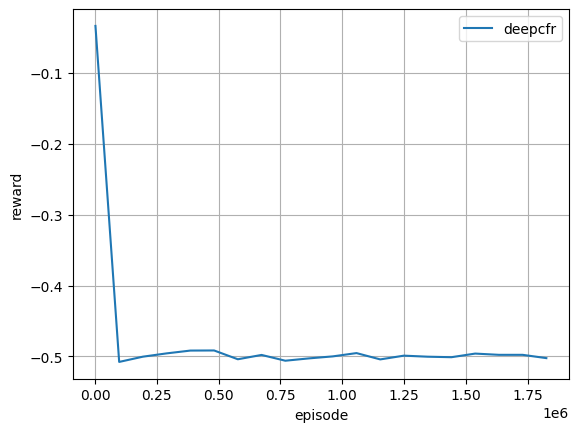

In [ ]:
nv = rlcard.make('leduc-holdem', config={'allow_step_back': True})
eval_env = rlcard.make('leduc-holdem')

initial_states = env.reset()
example_state = initial_states[0]['obs']
state_shape = example_state.shape

deepcfr_agent = DeepCFRAgent(
    env,
    model_path="experiments/leduc_holdem_deepcfr_result/cfr_model",
    n_clusters=100,
    regret_hidden_sizes=[128, 128],
    policy_hidden_sizes=[128, 128],
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    lr=1e-3,
    batch_size=64
)

deepcfr_agent.load()

eval_env.set_agents([deepcfr_agent, RandomAgent(num_actions=env.num_actions)])

with Logger("experiments/leduc_holdem_deepcfr_result") as logger:
    num_iterations = 1000
    for it in range(num_iterations):
        deepcfr_agent.train()
        print(f'\rIteration {it}', end='')
        if it % 50 == 0:
            performance = tournament(eval_env, 10000)[0]
            logger.log_performance(env.timestep, performance)
    csv_path, fig_path = logger.csv_path, logger.fig_path

plot_curve(csv_path, fig_path, 'deepcfr')

## PPO+LSTM

In [ ]:
class LSTMPolicy(nn.Module):
    def __init__(self, input_size, num_actions, hidden_size=128):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.policy_fc = nn.Linear(hidden_size, num_actions)
        self.value_fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x, hx, cx):
        # x: (batch, seq_len, input_size)
        out, (hx, cx) = self.lstm(x, (hx, cx))
        out = out[:, -1, :] 
        policy_logits = self.policy_fc(out)
        value = self.value_fc(out)
        return policy_logits, value, (hx, cx)

class PPOAgentWithLSTM:
    def __init__(self, 
                 num_actions,
                 input_size,
                 hidden_size=128,
                 lr=1e-4,
                 gamma=0.99,
                 lam=0.95,
                 clip_range=0.2,
                 K_epochs=3,
                 batch_size=128,
                 device=None,
                 entropy_coef=0.01):
        
        self.num_actions = num_actions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gamma = gamma
        self.lam = lam
        self.clip_range = clip_range
        self.K_epochs = K_epochs
        self.batch_size = batch_size
        self.entropy_coef = entropy_coef
        
        self.device = device if device is not None else torch.device("cpu")
        
        self.policy = LSTMPolicy(input_size, num_actions, hidden_size).to(self.device)
        self.policy_old = LSTMPolicy(input_size, num_actions, hidden_size).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        self.reset_rollout_storage()
        
        self.use_raw = False
        
    def reset_rollout_storage(self):
        # Each observation is stored as a tensor of shape (1, input_size)
        self.observations = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.hx = torch.zeros(1, 1, self.hidden_size, device=self.device)
        self.cx = torch.zeros(1, 1, self.hidden_size, device=self.device)
        
    def step(self, state):
        obs = state['obs']
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=self.device).view(1, 1, -1)
        with torch.no_grad():
            logits, value, (self.hx, self.cx) = self.policy(obs_tensor, self.hx, self.cx)
            probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        legal_actions = list(state['legal_actions'].keys())
        probs = remove_illegal(probs, legal_actions)
        action = np.random.choice(len(probs), p=probs)
        log_prob = np.log(probs[action] + 1e-8)
        # Store observation as tensor with shape (1, input_size)
        self.observations.append(obs_tensor.squeeze(0))
        self.actions.append(action)
        self.logprobs.append(log_prob)
        return action

    def eval_step(self, state):
        obs = state['obs']
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=self.device).view(1, 1, -1)
        with torch.no_grad():
            logits, _, _ = self.policy(obs_tensor, self.hx, self.cx)
            probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        legal_actions = list(state['legal_actions'].keys())
        probs = remove_illegal(probs, legal_actions)
        action = np.random.choice(len(probs), p=probs)
        info = {'probs': {state['raw_legal_actions'][i]: float(probs[list(state['legal_actions'].keys())[i]])
                          for i in range(len(state['legal_actions']))}}
        return action, info

    def record_reward(self, reward, done):
        self.rewards.append(reward)
        self.dones.append(done)

    def finish_trajectory_and_train(self):
        if not self.observations:
            return
        
        # Stack stored observations: each of shape (1, input_size)
        obs_tensor = torch.cat(self.observations, dim=0) 
        # Add sequence dimension: (N, 1, input_size)
        if obs_tensor.dim() == 2:
            obs_tensor = obs_tensor.unsqueeze(1)
        
        actions_np = np.array(self.actions)
        log_probs_np = np.array(self.logprobs)
        rewards_np = np.array(self.rewards)
        dones_np = np.array(self.dones, dtype=np.float32)
        
        # Compute value estimates using the old policy
        values = []
        hx_local = torch.zeros(1, 1, self.hidden_size, device=self.device)
        cx_local = torch.zeros(1, 1, self.hidden_size, device=self.device)
        for obs in self.observations:
            # Only add one dimension (batch) to get shape (1, 1, input_size)
            obs_seq = obs.unsqueeze(0)
            with torch.no_grad():
                _, v, (hx_local, cx_local) = self.policy_old(obs_seq, hx_local, cx_local)
            values.append(v.item())
        values_np = np.array(values)
        
        advantages, returns = self.compute_gae(rewards_np, values_np, dones_np)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        actions_t = torch.LongTensor(actions_np).to(self.device)
        log_probs_old_t = torch.FloatTensor(log_probs_np).to(self.device)
        returns_t = torch.FloatTensor(returns).to(self.device)
        advantages_t = torch.FloatTensor(advantages).to(self.device)
        
        self.policy_old.load_state_dict(self.policy.state_dict())
        dataset_size = len(actions_np)
        for _ in range(self.K_epochs):
            batch_size_current = obs_tensor.size(0)
            hx_batch = torch.zeros(1, batch_size_current, self.hidden_size, device=self.device)
            cx_batch = torch.zeros(1, batch_size_current, self.hidden_size, device=self.device)
            
            logits, value, _ = self.policy(obs_tensor, hx_batch, cx_batch)
            probs = torch.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            log_probs_new = dist.log_prob(actions_t)
            
            ratio = torch.exp(log_probs_new - log_probs_old_t)
            surr1 = ratio * advantages_t
            surr2 = torch.clamp(ratio, 1.0 - self.clip_range, 1.0 + self.clip_range) * advantages_t
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = F.mse_loss(value.squeeze(-1), returns_t)
            entropy = dist.entropy().mean()
            loss = policy_loss + 0.5 * value_loss - self.entropy_coef * entropy
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        self.reset_rollout_storage()
    
    def compute_gae(self, rewards, values, dones):
        advantages = np.zeros_like(rewards)
        returns = np.zeros_like(rewards)
        last_adv = 0.0
        last_return = 0.0
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = 0.0
                next_non_terminal = 1.0 - dones[t]
            else:
                next_value = values[t+1]
                next_non_terminal = 1.0 - dones[t]
            delta = rewards[t] + self.gamma * next_value * next_non_terminal - values[t]
            advantages[t] = last_adv = delta + self.gamma * self.lam * next_non_terminal * last_adv
            returns[t] = last_return = rewards[t] + self.gamma * next_value * next_non_terminal
        return advantages, returns

    def save(self, path="ppo_lstm_model"):
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(self.policy.state_dict(), os.path.join(path, "policy.pt"))
        torch.save(self.policy_old.state_dict(), os.path.join(path, "policy_old.pt"))
    
    def load(self, path="ppo_lstm_model"):
        if not os.path.exists(path):
            return
        self.policy.load_state_dict(torch.load(os.path.join(path, "policy.pt"), map_location=self.device))
        self.policy_old.load_state_dict(torch.load(os.path.join(path, "policy_old.pt"), map_location=self.device))

Episode 0
----------------------------------------
  episode      |  6
  reward       |  -0.07815
----------------------------------------
 => performance: -0.07815
Episode 100
----------------------------------------
  episode      |  241
  reward       |  0.0119
----------------------------------------
 => performance: 0.0119
Episode 200
----------------------------------------
  episode      |  486
  reward       |  0.09755
----------------------------------------
 => performance: 0.09755
Episode 300
----------------------------------------
  episode      |  822
  reward       |  0.30805
----------------------------------------
 => performance: 0.30805
Episode 400
----------------------------------------
  episode      |  1265
  reward       |  0.6509
----------------------------------------
 => performance: 0.6509
Episode 500
----------------------------------------
  episode      |  1791
  reward       |  0.96645
----------------------------------------
 => performance: 0.96645
Ep

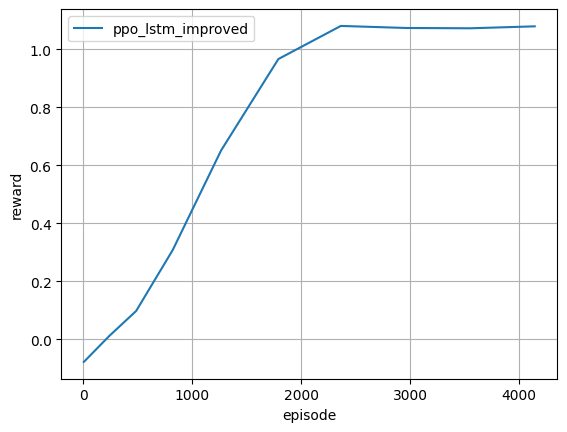

In [79]:
env = rlcard.make('leduc-holdem', config={'allow_step_back': True})
eval_env = rlcard.make('leduc-holdem')

initial_states = env.reset()
obs_dim = initial_states[0]['obs'].flatten().shape[0]

agent = PPOAgentWithLSTM(
    num_actions=env.num_actions,
    input_size=obs_dim,
    hidden_size=128,
    lr=1e-4,
    gamma=0.99,
    lam=0.95,
    clip_range=0.2,
    K_epochs=3,
    batch_size=128,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    entropy_coef=0.01
)

eval_env.set_agents([agent, RandomAgent(num_actions=env.num_actions)])

with Logger("experiments/leduc_holdem_ppo_lstm_improved") as logger:
    for episode in range(num_episodes):
        state = env.reset()
        agent.reset_rollout_storage()
        while not env.is_over():
            current_player = env.get_player_id()
            s = env.get_state(current_player)
            action = agent.step(s)
            next_state, reward = env.step(action)
            agent.record_reward(reward, env.is_over())
        agent.finish_trajectory_and_train()
        print(f"\rEpisode {episode}", end='')
        if episode % 100 == 0:
            performance = tournament(eval_env, 10000)[0]
            logger.log_performance(env.timestep, performance)
            print(f" => performance: {performance}")
    csv_path, fig_path = logger.csv_path, logger.fig_path

plot_curve(csv_path, fig_path, 'ppo_lstm_improved')

I can see that, over the course of training, my PPO+LSTM agent’s average reward steadily rises from around 0.2 to surpass 1.0. This suggests that my modifications—such as storing entire episodes, normalizing advantages, and adding an entropy bonus—are helping the agent learn a stronger strategy. By around 3,000 to 4,000 episodes, the agent appears to exploit the random opponent quite effectively, resulting in consistently high rewards. While the curve eventually levels off, it demonstrates that my improvements significantly increased performance compared to the initial versions.

In [ ]:
env = rlcard.make('leduc-holdem', config={'allow_step_back': True})

cfr_agent = CFRAgent(env, "experiments/leduc_holdem_cfr_result/cfr_model")
cfr_agent.load()

initial_states = env.reset()
obs_dim = initial_states[0]['obs'].flatten().shape[0]

ppo_lstm_agent = PPOAgentWithLSTM(
    num_actions=env.num_actions,
    input_size=obs_dim,
    hidden_size=128,
    lr=1e-4,
    gamma=0.99,
    lam=0.95,
    clip_range=0.2,
    K_epochs=3,
    device=None, 
    entropy_coef=0.01
)

compare_models(
    env_name='leduc-holdem',
    model1=ppo_lstm_agent, 
    model1_name="PPO+LSTM",
    model2=cfr_agent, 
    model2_name="CFRAgent",
    num_games=1000
)

Average reward for PPO+LSTM: 0.0135
Average reward for CFRAgent: -0.0135


(np.float64(0.0135), np.float64(-0.0135))

## 2-Player Agent Comparisons

In [ ]:
def compare_2p_agents_round_robin(env_name, agents, agent_names, num_games=10000):
    """
    Compare performance of 2-player agents in a round-robin tournament.
    Each pair of agents will be evaluated (with swapped seating orders)
    and their average rewards will be aggregated.
    """
    # Dictionary to store the list of average rewards from each pairing
    rewards_dict = {name: [] for name in agent_names}
    
    # Generate all pairwise combinations (round-robin)
    pairs = list(itertools.combinations(range(len(agents)), 2))
    for i, j in pairs:
        env = rlcard.make(env_name)
        
        env.set_agents([agents[i], agents[j]])
        rewards_order1 = tournament(env, num_games)
        
        env.set_agents([agents[j], agents[i]])
        rewards_order2 = tournament(env, num_games)
        
        avg_reward_i = (rewards_order1[0] + rewards_order2[1]) / 2.0
        avg_reward_j = (rewards_order1[1] + rewards_order2[0]) / 2.0
        
        rewards_dict[agent_names[i]].append(avg_reward_i)
        rewards_dict[agent_names[j]].append(avg_reward_j)
        
        print(f"Pair ({agent_names[i]}, {agent_names[j]}):")
        print(f"  {agent_names[i]}: {avg_reward_i:.4f}")
        print(f"  {agent_names[j]}: {avg_reward_j:.4f}")
        print("-" * 40)
    
    overall_rewards = {}
    for name, rewards in rewards_dict.items():
        overall_rewards[name] = np.mean(rewards)
        print(f"Overall average reward for {name}: {overall_rewards[name]:.4f}")
    
    return overall_rewards


In [78]:
env = rlcard.make('leduc-holdem', config={'allow_step_back': True})

agent1 = CFRAgent(env, "experiments/leduc_holdem_cfr_result/cfr_model")
agent1.load()

agent2 = CFRPlusAgent(env, "experiments/leduc_holdem_cfr_plus_result/cfr_model")
agent2.load()

agent3 = CFRPlusAgentWithBaseline(env, "experiments/leduc_holdem_cfr_plus_baseline_result/cfr_model")
agent3.load()

agent4 = CFRPlusAgentWithBaselineAbstract(
    env,
    model_path="experiments/leduc_holdem_cfr_plus_baseline_abstract_result/cfr_model",
    n_clusters=100  # Adjust the number of clusters as needed
)
agent4.load()

agents = [agent1, agent2, agent3, agent4]
agent_names = ["CFRAgent", "CFRPlusAgent", "CFR+ with Baseline", "CFR+ with Baseline & Abstraction"]

overall_rewards = compare_2p_agents_round_robin('leduc-holdem', agents, agent_names, num_games=100)

Pair (CFRAgent, CFRPlusAgent):
  CFRAgent: 0.0475
  CFRPlusAgent: -0.0475
----------------------------------------
Pair (CFRAgent, CFR+ with Baseline):
  CFRAgent: 0.0200
  CFR+ with Baseline: -0.0200
----------------------------------------
Pair (CFRAgent, CFR+ with Baseline & Abstraction):
  CFRAgent: 0.1050
  CFR+ with Baseline & Abstraction: -0.1050
----------------------------------------
Pair (CFRPlusAgent, CFR+ with Baseline):
  CFRPlusAgent: -0.0850
  CFR+ with Baseline: 0.0850
----------------------------------------
Pair (CFRPlusAgent, CFR+ with Baseline & Abstraction):
  CFRPlusAgent: 0.0125
  CFR+ with Baseline & Abstraction: -0.0125
----------------------------------------
Pair (CFR+ with Baseline, CFR+ with Baseline & Abstraction):
  CFR+ with Baseline: 0.0000
  CFR+ with Baseline & Abstraction: 0.0000
----------------------------------------
Overall average reward for CFRAgent: 0.0575
Overall average reward for CFRPlusAgent: -0.0400
Overall average reward for CFR+ with B

/var/folders/lx/83qzj14d62j7kt5mrql9j7n80000gn/T/ipykernel_7415/3842757341.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  probs = self.action_probs(state['obs'].tostring(), list(state['legal_actions'].keys()), self.average_policy)
